
# Efficient-spiking-networks/ECG/adapt_srnn_0.844_gpu-v1.py
## From public github repo byin-cwi /
---



#### Imports

In [ ]:
"""
this code works,
1. 36 recurrent neurons will lead to 84.4 percent on testset
2. 24 recurrent neurons will lead to 81.8 percent on testset
"""

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR,MultiStepLR
import matplotlib.pyplot as plt
import math
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
from sklearn.metrics import confusion_matrix
import scipy.io

#### Initializing some physiological and technical model parameters

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device =  torch.device("cpu")
print('device: ',device)

'''
STEP 3a_v2: CREATE Adaptative spike MODEL CLASS
'''
b_j0 = 0.01  # neural threshold baseline
tau_m = 20  # ms membrane potential constant
R_m = 1  # membrane resistance
dt = 1  #
gamma = .5  # gradient scale #TM: Learning rate ?
lens = 0.5

surrograte_type = 'MG'
print('surrograte_type: ',surrograte_type)

neuron_type = 'adaptive'
print('neuron_type: ',neuron_type)

device:  cpu
surrograte_type:  MG
neuron_type:  adaptive


#### Standard Gaussian distribution used for the new gradiant method

In [ ]:
def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma

#### From autograd baseclass for individual gradient implementation. If surrogate set to 'MG', backward propagation is implemented using the multi-gaussian as defined in the paper with three normal distributions centered on the neuron's membrane potential.

In [ ]:
# define approximate firing function

class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        scale = 6.0
        hight = .15
        if surrograte_type == 'G':
            temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
        elif surrograte_type == 'MG':
            temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
                - gaussian(input, mu=lens, sigma=scale * lens) * hight \
                - gaussian(input, mu=-lens, sigma=scale * lens) * hight
        elif surrograte_type =='linear':
            temp = F.relu(1-input.abs())
        elif surrograte_type == 'slayer':
            temp = torch.exp(-5*input.abs())
        return grad_input * temp.float() * gamma
# membrane potential update

act_fun_adp = ActFun_adp.apply

#### Deciding between ALIF and LIF neural models, the membrane update step is defined.

In [ ]:
if neuron_type =='adaptive':
    def mem_update_adp(inputs, mem, spike, tau_m,tau_adp, b, isAdapt=1, dt=1):
        alpha = torch.exp(-1. * dt / tau_m)#.cuda()
        ro = torch.exp(-1. * dt / tau_adp)#.cuda()
        # tau_adp is tau_adaptative which is learnable # add requiregredients
        if isAdapt:
            beta = 1.8
        else:
            beta = 0.

        b = ro * b + (1 - ro) * spike
        B = b_j0 + beta * b

        mem = mem * alpha + (1 - alpha) * R_m * inputs - B * spike * dt
        inputs_ = mem - B
        spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
        return mem, spike, B, b

if neuron_type  == 'LIF':
    def mem_update_adp(inputs, mem, spike, tau_m, tau_adp, b, dt=1, isAdapt=1):

        b = 0
        B = .5
        alpha = torch.exp(-1. * dt / tau_adp)#.cuda()
        mem = mem *.618 + inputs#*(1- alpha)
        inputs_ = mem - B
        spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
        mem = (1-spike)*mem 
        return mem, spike, B, b

#### SRNN model with individualized forward feeding and prediction

In [ ]:
class RNN_s(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, sub_seq_length,criterion):
        super(RNN_s, self).__init__()
        self.criterion = criterion

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.sub_seq_length = sub_seq_length
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

        self.tau_adp_h = nn.Parameter(torch.Tensor(hidden_size))
        self.tau_adp_o = nn.Parameter(torch.Tensor(output_size))
        
        self.tau_m_h = nn.Parameter(torch.Tensor(hidden_size))
        self.tau_m_o = nn.Parameter(torch.Tensor(output_size))
        
        nn.init.orthogonal_(self.h2h.weight)
        nn.init.xavier_uniform_(self.i2h.weight)
        nn.init.xavier_uniform_(self.h2o.weight)
        nn.init.constant_(self.i2h.bias, 0)
        nn.init.constant_(self.h2h.bias, 0)
        nn.init.constant_(self.h2o.bias, 0)

        nn.init.constant_(self.tau_adp_h, 7) #7
        nn.init.constant_(self.tau_adp_o, 100)
        nn.init.constant_(self.tau_m_h, 20) #7
        nn.init.constant_(self.tau_m_o, 20)
        
        self.b_h = self.b_o = 0

    def forward(self, input,labels):
        self.b_h = self.b_o = b_j0
        total_spikes = 0
        # Feed in the whole sequence
        batch_size, seq_num, input_dim = input.shape
        hidden_mem = hidden_spike = (torch.rand(batch_size, self.hidden_size)*b_j0)#TM:.cuda()
        output_mem = output_spike = out_spike = (torch.rand(batch_size, self.output_size)*b_j0)#TM:.cuda()
        output_spike_sum = torch.zeros(batch_size,seq_num, self.output_size)#TM:.cuda()
        self.b_h = self.b_o = 0.01

        max_iters = 1301
        loss = 0

        output_ = []
        I_h = []
        predictions = []
        for i in range(max_iters): # Go through the sequence
            if i < seq_num:
                input_x = input[:, i, :]
            else:
                input_x = torch.zeros(batch_size,input_dim)

            #################   update states  #########################
            h_input = self.i2h(input_x.float()) + self.h2h(hidden_spike)
            hidden_mem, hidden_spike, theta_h, self.b_h = mem_update_adp(h_input,hidden_mem, hidden_spike,self.tau_m_h,
                                                                            self.tau_adp_h, self.b_h,isAdapt=0)#0

            I_h.append(h_input.data.cpu().numpy())
            o_input = self.h2o(hidden_spike)
            output_mem, output_spike, theta_o, self.b_o = mem_update_adp(o_input,output_mem,output_spike,self.tau_m_o, 
                                                                         self.tau_adp_o, self.b_o,isAdapt=1)#, dt=input_dt_o)
            output_spike_sum[:,i,:] = output_spike
            total_spikes = total_spikes + int(hidden_spike.sum() + output_spike.sum())
            #################   classification  #########################
            if i >= self.sub_seq_length:
                output_sumspike = output_mem #output_spike_sum[:, i-1:i, :].sum(axis=1)
                output_sumspike = F.log_softmax(output_sumspike,dim=1)

                predictions.append(output_sumspike.data.cpu().numpy())
                output_.append(output_sumspike.data.cpu().numpy())
                loss += self.criterion(output_sumspike, labels[:, i])

        predictions = torch.tensor(predictions)
        return predictions, loss , total_spikes

    def predict(self,input, lablel):
        prediction = self.forward(input, lablel)
        # prediction, _, total_spikes = self.forward(dt_h, dt_o, max_i, input, lablel)
        return prediction

#### Train model in-place by reference, return training accuracies

In [ ]:
def train(model,dims, loader,optimizer,scheduler=None,num_epochs=10):
    best_acc = 0
    path = 'model/'  # .pth'
    acc_list=[]
    for epoch in range(num_epochs):
        train_acc = 0
        train_loss_sum = 0
        sum_samples = 0
        for i, (images, labels) in enumerate(loader):
            images = images.view(-1, dims["samples"], dims["input"]).requires_grad_().to(device)#images.view(-1, num_samples, input_dim).requires_grad_().to(device)
            labels = labels.view((-1,dims["samples"])).long().to(device)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            # Forward pass to get output/logits
            predictions, train_loss,_ = model(images, labels)

            _, predicted = torch.max(predictions.data, 2)
            
            # Getting gradients w.r.t. parameters
            train_loss.backward()
            train_loss_sum += train_loss
            optimizer.step()

            labels = labels.cpu()
            #print(predicted.type(), labels.type())
            predicted = predicted.cpu().t()
            train_acc += (predicted == labels[:, dims["sub_seq"]:predicted.shape[1] + dims["sub_seq"]]).sum()
            sum_samples = sum_samples + predicted.numel()
            # train_acc += (predicted == labels).sum()
        if scheduler is not None:
            scheduler.step()
        train_acc = train_acc.data.cpu().numpy() / sum_samples
        if train_acc>best_acc and train_acc>0.80:
            best_acc = train_acc
            torch.save(model.state_dict(), path+str(best_acc)[:5]+'-wt-new.pth')

        acc_list.append(train_acc)
        print('epoch: {:3d}, Train Loss: {:.4f}, Train Acc: {:.4f}'.format(epoch,
                                                                           train_loss_sum.item()/len(loader)/(1300-dims["sub_seq"]),
                                                                           train_acc), flush=True)
    return acc_list

#### Some helper functions

In [ ]:
import scipy.signal as ssg
def convert_seq(x,threshold=0.03):
    l = len(x)
    x= ssg.savgol_filter(x, 5, 3)
    X = np.zeros((l,2))
    for i in range(len(x)-1):
        if x[i+1] - x[i] >= threshold:
            X[i,0] = 1
        elif x[i] - x[i+1] >= threshold:
            X[i,1] = 1
    return X


def expand_dim(x, N):
    y = np.zeros((x.shape[0], x.shape[1], N))
    for i in range(x.shape[0]):
        y[i, :, :] = np.tile(x[i,:], (N,1)).transpose()

    return y

def lbl_to_spike(prediction):
    N = len(prediction)
    detections = np.zeros(N)
    for i in range(1, N):
        if (prediction[i] != prediction[i-1]):
            detections[i] = prediction[i]+1
    return detections


def calculate_stats(prediction, lbl, tol):
    decisions = lbl_to_spike(prediction)
    labs = lbl_to_spike(lbl)

    lbl_indices = np.nonzero(labs)
    lbl_indices = np.array(lbl_indices).flatten()

    dist = np.zeros((len(lbl_indices), 6))
    for i in range(len(lbl_indices)):
        index = lbl_indices[i]
        lab = int(labs[index])
        dec_indices = np.array(np.nonzero((decisions-lab) == 0)).flatten()  #indices where decisions == lab
        if len(dec_indices) == 0:
            dist[i, lab - 1] = 250
            continue
        j = np.argmin(np.abs(dec_indices - index))  # j is closest val in dec_indices to index
        dist[i, lab-1] = abs(dec_indices[j]-index)
        if (dist[i, lab-1] <= tol):
            decisions[dec_indices[j]] = 0 # mark as handled

    mean_error = np.mean(dist, axis=0)
    TP = np.sum(dist <= tol, axis=0)
    FN = np.sum(dist > tol, axis=0)

    FP = np.zeros(6)
    for i in decisions[(decisions > 0)]:
        FP[int(i-1)] += 1

    return mean_error, TP, FN, FP

def convert_dataset_wtime(mat_data):
    X = mat_data["x"]
    Y = mat_data["y"]
    t = mat_data["t"]
    Y = np.argmax(Y[:, :, :], axis=-1)
    d1,d2 =  t.shape

    # dt = np.zeros((size(t[:, 1]), size(t[1, :])))
    dt = np.zeros((d1,d2))
    for trace in range(d1):
        dt[trace, 0] = 1
        dt[trace, 1:] = t[trace, 1:] - t[trace, :-1]

    return dt, X, Y


def load_max_i(mat_data):
    max_i = mat_data["max_i"]
    return np.array(max_i.squeeze(),dtype=np.float16)

#### Step by Step execution

In [ ]:
train_mat = scipy.io.loadmat('SRNN_Datasets/QTDB_train.mat')
test_mat = scipy.io.loadmat('SRNN_Datasets/QTDB_test.mat')

In [ ]:
train_dt, train_x, train_y = convert_dataset_wtime(train_mat)
train_max_i = load_max_i(train_mat)
test_dt, test_x, test_y = convert_dataset_wtime(test_mat)
test_max_i = load_max_i(test_mat)
nb_of_sample, seq_dim, input_dim = np.shape(train_x)
print('sequence length: {} , input dimension: {}'.format(seq_dim, input_dim))
print('training dataset distribution: ',train_y.shape)
print('test dataset distribution: ',test_y.shape)

sequence length: 1301 , input dimension: 4
training dataset distribution:  (618, 1301)
test dataset distribution:  (141, 1301)


In [ ]:
# STEP 2: MAKING DATASET ITERABLE
batch_size = 64
n_iters = 300
lens = 0.5  # hyper-parameters of approximate function
#num_epochs = 1#250  # n_iters / (len(train_dataset) / batch_size)
num_epochs = 0#400 #400
#nb_of_batch = nb_of_sample // batch_size

sub_seq_length = 10
#L = seq_dim - sub_seq_length
hidden_dim = 36
if neuron_type =='LIF': hidden_dim = 36
output_dim = 6

train_data = TensorDataset(torch.from_numpy(train_x*1.),torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=False)
test_data = TensorDataset(torch.from_numpy(test_x*1.),torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=False)

criterion = nn.NLLLoss()
model = RNN_s(input_size=input_dim, hidden_size=hidden_dim,
              output_size=output_dim, sub_seq_length=sub_seq_length,criterion=criterion)

model.to(device)


learning_rate =1e-2

base_params = [model.i2h.weight, model.i2h.bias, model.h2h.weight,
                model.h2h.bias, model.h2o.weight, model.h2o.bias]

optimizer = torch.optim.Adam([
    {'params': base_params},
    {'params': model.tau_m_h, 'lr': learning_rate * 3},
    {'params': model.tau_m_o, 'lr': learning_rate * 2},
    {'params': model.tau_adp_h, 'lr': learning_rate * 3},
    {'params': model.tau_adp_o, 'lr': learning_rate * 2}, ],
    lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=100, gamma=.75) # gaussian
scheduler = StepLR(optimizer, step_size=100, gamma=.5) # LIF

# training network
dims = {
    "samples": seq_dim,
    "input": input_dim,
    "hidden": hidden_dim,
    "output": output_dim,
    "sub_seq": sub_seq_length
}

In [ ]:
num_epochs = 5

In [ ]:
model

RNN_s(
  (criterion): NLLLoss()
  (i2h): Linear(in_features=4, out_features=36, bias=True)
  (h2h): Linear(in_features=36, out_features=36, bias=True)
  (h2o): Linear(in_features=36, out_features=6, bias=True)
)

In [ ]:
train_acc_list = train(model,dims, train_loader,optimizer,scheduler,num_epochs=num_epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


epoch:   0, Train Loss: 1.6057, Train Acc: 0.3132
epoch:   1, Train Loss: 1.5205, Train Acc: 0.3199
epoch:   2, Train Loss: 1.4820, Train Acc: 0.3338
epoch:   3, Train Loss: 1.4299, Train Acc: 0.3532
epoch:   4, Train Loss: 1.3747, Train Acc: 0.4362


In [ ]:
model

RNN_s(
  (criterion): NLLLoss()
  (i2h): Linear(in_features=4, out_features=36, bias=True)
  (h2h): Linear(in_features=36, out_features=36, bias=True)
  (h2o): Linear(in_features=36, out_features=6, bias=True)
)

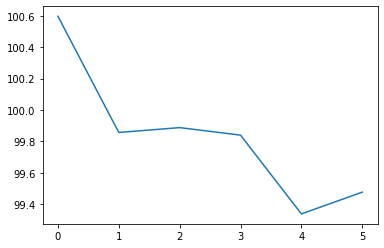

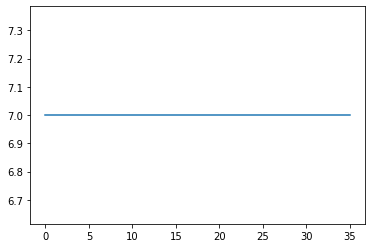

In [ ]:
test_seq_dim = test_x.shape[1]

tau_adp_o = model.tau_adp_o.detach().cpu().numpy()
plt.plot(tau_adp_o)
plt.show()
tau_adp_h = model.tau_adp_h.detach().cpu().numpy()
plt.plot(tau_adp_h)
plt.show()

In [ ]:
acc = []
predicted_list = []
labels_list = []
fr_list = []
stats = {"err": 0, "TP": 0, "FP": 0, "FN": 0}
for i in range(len(test_x)):
    x_emp = test_x[i:i+1]
    y_emp = test_y[i:i+1]

    images = torch.tensor(x_emp*1.).view((-1, test_seq_dim, input_dim)).requires_grad_().to(device)
    labels = torch.tensor(y_emp).view((-1, test_seq_dim)).long().to(device)

    pred,_,spike=  model.forward(images,labels) #model.predict(images,labels)
    # print(pred.shape, pred.dtype)
    # print(pred.numpy().shape )
    a_len = 1301-sub_seq_length
    a_np = pred.data.cpu().numpy().reshape(a_len, 6)
    a_np_pred = np.argmax(a_np, axis=1)
    labels = y_emp[0, sub_seq_length:sub_seq_length+a_len].reshape(a_len)
    acc_ = (a_np_pred == labels).sum() / int(a_len)
    acc.append(acc_)
    labels_list.extend(labels)
    predicted_list.extend(a_np_pred)
    fr_list.append(spike)
    if i%10 == 0:
        print(i,np.mean(acc))

    err, TP, FN, FP = calculate_stats(a_np_pred[30:-30], labels[30:-30], 0.150 * 250)
    stats["err"] = stats["err"] + err / len(test_x)
    stats["TP"] = stats["TP"] + TP
    stats["FP"] = stats["FP"] + FP
    stats["FN"] = stats["FN"] + FN

print('fr:',np.mean(fr_list)/1301./42.)
test_acc = np.mean(acc)
print('test accuracy: ',np.mean(acc))

predicted_list = np.array(predicted_list).reshape((-1,))
labels_list = np.array(labels_list).reshape(((-1,)))
cm = confusion_matrix(labels_list, predicted_list)
print(cm)
from sklearn import metrics

print("classification report :", metrics.classification_report(labels_list, predicted_list))

0 0.576297443841983
10 0.5620026758678967
20 0.5219283685588876
30 0.5194023137852628
40 0.5286505072641741
50 0.5245363831047524
60 0.49990476311411913
70 0.510315183120411
80 0.5006646202101921
90 0.5058179620534384
100 0.5133943293632229
110 0.5162141227207068
120 0.5131200747706628
130 0.5117046375080565
140 0.5084848185199224
fr: 0.3775625535237618
test accuracy:  0.5084848185199224
[[ 7253     0     0     0  2446 32100]
 [ 1760     0     0     2   180  8203]
 [  384     0     0    20   344  9092]
 [   54     0     0    18  2388  6605]
 [  496     0     0     2 38565 16822]
 [ 5643     0     0     0  2930 46724]]
classification report :               precision    recall  f1-score   support

           0       0.47      0.17      0.25     41799
           1       0.00      0.00      0.00     10145
           2       0.00      0.00      0.00      9840
           3       0.43      0.00      0.00      9065
           4       0.82      0.69      0.75     55885
           5       0.39  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Execution of .py call:

In [ ]:
#if __name__ == '__main__':
# STEP 2: LOADING DATASET
train_mat = scipy.io.loadmat('SRNN_Datasets/QTDB_train.mat')
test_mat = scipy.io.loadmat('SRNN_Datasets/QTDB_test.mat')

# # old dataset
# xxt = np.load('dataset/test_y.npy')
# print(xxt.shape)
# xxt = np.load('dataset/xxt.npy')
# yyt = np.load('dataset/yyt.npy')
# xxv = np.load('dataset/xxv.npy')
# yyv = np.load('dataset/yyv.npy')

train_dt, train_x, train_y = convert_dataset_wtime(train_mat)
train_max_i = load_max_i(train_mat)
test_dt, test_x, test_y = convert_dataset_wtime(test_mat)
test_max_i = load_max_i(test_mat)

nb_of_sample, seq_dim, input_dim = np.shape(train_x)
print('sequence length: {} , input dimension: {}'.format(seq_dim, input_dim))
print('training dataset distribution: ',train_y.shape)
print('test dataset distribution: ',test_y.shape)

# STEP 2: MAKING DATASET ITERABLE
batch_size = 64
n_iters = 300000
lens = 0.5  # hyper-parameters of approximate function
#num_epochs = 1#250  # n_iters / (len(train_dataset) / batch_size)
num_epochs = 0#400 #400
#nb_of_batch = nb_of_sample // batch_size

sub_seq_length = 10
#L = seq_dim - sub_seq_length
hidden_dim = 36
if neuron_type =='LIF': hidden_dim = 36
output_dim = 6

train_data = TensorDataset(torch.from_numpy(train_x*1.),torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=False)
test_data = TensorDataset(torch.from_numpy(test_x*1.),torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=False)

criterion = nn.NLLLoss()
model = RNN_s(input_size=input_dim, hidden_size=hidden_dim,
              output_size=output_dim, sub_seq_length=sub_seq_length,criterion=criterion)

model.to(device)


learning_rate =1e-2

base_params = [model.i2h.weight, model.i2h.bias, model.h2h.weight,
                model.h2h.bias, model.h2o.weight, model.h2o.bias]

optimizer = torch.optim.Adam([
    {'params': base_params},
    {'params': model.tau_m_h, 'lr': learning_rate * 3},
    {'params': model.tau_m_o, 'lr': learning_rate * 2},
    {'params': model.tau_adp_h, 'lr': learning_rate * 3},
    {'params': model.tau_adp_o, 'lr': learning_rate * 2}, ],
    lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=100, gamma=.75) # gaussian
scheduler = StepLR(optimizer, step_size=100, gamma=.5) # LIF

# training network
dims = {
    "samples": seq_dim,
    "input": input_dim,
    "hidden": hidden_dim,
    "output": output_dim,
    "sub_seq": sub_seq_length
}
# with sechdual
train_acc_list = train(model,dims, train_loader,optimizer,scheduler,num_epochs=num_epochs)
# without sechdual

# train_acc_list = train(model, dims, train_loader, optimizer, num_epochs=num_epochs) # gaussian
# test and visualization
test_seq_dim = test_x.shape[1]

tau_adp_o = model.tau_adp_o.detach().cpu().numpy()
plt.plot(tau_adp_o)
plt.show()
tau_adp_h = model.tau_adp_h.detach().cpu().numpy()
plt.plot(tau_adp_h)
plt.show()

acc = []
predicted_list = []
labels_list = []
fr_list = []
stats = {"err": 0, "TP": 0, "FP": 0, "FN": 0}
for i in range(len(test_x)):
    x_emp = test_x[i:i+1]
    y_emp = test_y[i:i+1]

    images = torch.tensor(x_emp*1.).view((-1, test_seq_dim, input_dim)).requires_grad_().to(device)
    labels = torch.tensor(y_emp).view((-1, test_seq_dim)).long().to(device)

    pred,_,spike=  model.forward(images,labels) #model.predict(images,labels)
    # print(pred.shape, pred.dtype)
    # print(pred.numpy().shape )
    a_len = 1301-sub_seq_length
    a_np = pred.data.cpu().numpy().reshape(a_len, 6)
    a_np_pred = np.argmax(a_np, axis=1)
    labels = y_emp[0, sub_seq_length:sub_seq_length+a_len].reshape(a_len)
    acc_ = (a_np_pred == labels).sum() / int(a_len)
    acc.append(acc_)
    labels_list.extend(labels)
    predicted_list.extend(a_np_pred)
    fr_list.append(spike)
    if i%10 == 0:
        print(i,np.mean(acc))

    err, TP, FN, FP = calculate_stats(a_np_pred[30:-30], labels[30:-30], 0.150 * 250)
    stats["err"] = stats["err"] + err / len(test_x)
    stats["TP"] = stats["TP"] + TP
    stats["FP"] = stats["FP"] + FP
    stats["FN"] = stats["FN"] + FN

print('fr:',np.mean(fr_list)/1301./42.)
test_acc = np.mean(acc)
print('test accuracy: ',np.mean(acc))

predicted_list = np.array(predicted_list).reshape((-1,))
labels_list = np.array(labels_list).reshape(((-1,)))
cm = confusion_matrix(labels_list, predicted_list)
print(cm)
from sklearn import metrics

print("classification report :", metrics.classification_report(labels_list, predicted_list))
path = './model_'+str(test_acc)+'_'+str(hidden_dim)+'_MG.pth'
torch.save(model.state_dict(), path)
